In [12]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [2]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [3]:
# Normalise data

y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)

In [4]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X[:ntrain], X[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## Recurrent Neural Network Model #1 : Long Short-Term Memory (LSTM)

### Create sliding window sequences

In [5]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train LSTM model

In [21]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)  # Output layer for price prediction
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


c:\Users\kylie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1384676.2500 - val_loss: 97923.9531
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 350071.8438 - val_loss: 86285.8125
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 324319.5625 - val_loss: 42265.6953
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 186028.9844 - val_loss: 40154.3086
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 123946.6484 - val_loss: 30712.5898
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 83493.4219 - val_loss: 24095.2598
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 57116.7500 - val_loss: 6352.8970
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 39009.3672 - val_loss: 5077.5874
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32705.7188 - val_loss: 2112.3079
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 27368.5977 - val_loss: 2588.5525


### Make predictions and evaluate performance

In [30]:
# LSTM Predictions and Evaluation
y_pred_seq_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_lstm)

# Calculate LSTM Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_rescaled, y_pred_lstm)

# Display LSTM Metrics
print(f"LSTM Model - RMSE: {rmse_lstm}, MAE: {mae_lstm}, MAPE: {mape_lstm}%")



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model - RMSE: 2155.046137725571, MAE: 1569.3952977318845, MAPE: 14.140740923238251%


### Visualisation of results

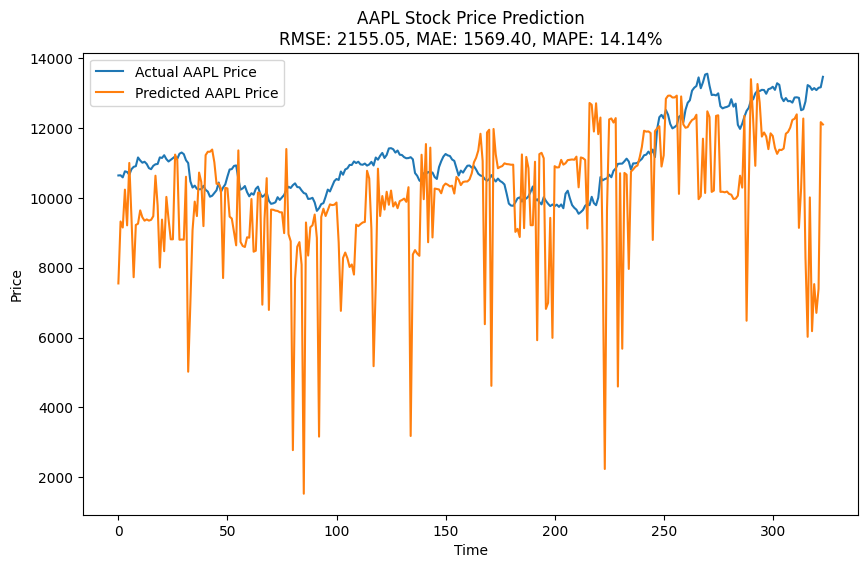

In [23]:
# Plot actual vs predicted prices with metrics in the title
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred, label='Predicted AAPL Price')
plt.title(f'AAPL Stock Price Prediction\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
# Store metrics for different models
results = pd.DataFrame({
    'Model': ['LSTM'],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE (%)': [mape]
})

print(results)


  Model         RMSE          MAE   MAPE (%)
0  LSTM  2155.046138  1569.395298  14.140741


## Recurrent Neural Network Model #2 : GRU

### Create sliding window sequences

In [25]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train GRU model

In [26]:
# Define GRU model
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


c:\Users\kylie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 12538.3672 - val_loss: 2734.4895
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6751.8765 - val_loss: 2821.8022
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3646.7236 - val_loss: 937.7244
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2389.5366 - val_loss: 1483.0771
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1694.5623 - val_loss: 381.7944
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1171.2019 - val_loss: 619.5251
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 928.6713 - val_loss: 596.2559
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 735.5330 - val_loss: 825.0060
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 542.8367 - val_loss: 536.2994
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 443.9187 - val_loss: 565.7679


### Make predictions and evaluate performance

In [31]:
# GRU Predictions and Evaluation
y_pred_seq_gru = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_seq_gru)

# Calculate GRU Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_gru))
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mape_gru = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru)

# Display GRU Metrics
print(f"GRU Model - RMSE: {rmse_gru}, MAE: {mae_gru}, MAPE: {mape_gru}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU Model - RMSE: 2405.0678741260044, MAE: 2307.735545440157, MAPE: 20.539399298562476%


### Visualise results

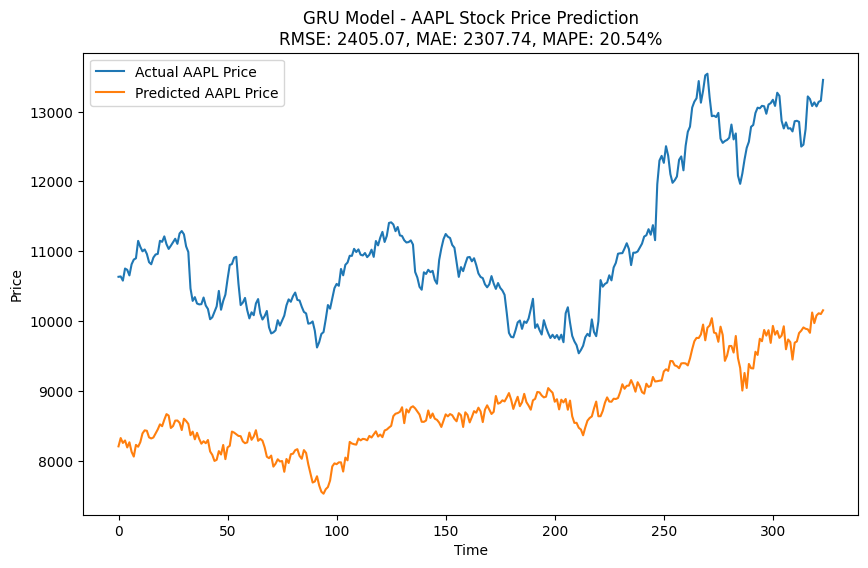

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred, label='Predicted AAPL Price')
plt.title(f'GRU Model - AAPL Stock Price Prediction\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of results of Model #1: LSTM and Model #2: GRU

In [32]:
# Store metrics for LSTM and GRU
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru],
    'MAPE (%)': [mape_lstm, mape_gru]
})

print(results)


  Model         RMSE          MAE   MAPE (%)
0  LSTM  2155.046138  1569.395298  14.140741
1   GRU  2405.067874  2307.735545  20.539399
